In [10]:
import pandas as pd
import numpy as np

import preprocessing as pp
import model
from train import train_model
from predict import predict

In [11]:
# Data loading
df_store = pd.read_csv('../data/store.csv')
df_train = pd.read_csv('../data/train.csv', low_memory=False)

## General pipeline test

### Model selection (Time-split cross-validation)

In [12]:
from sklearn.model_selection import TimeSeriesSplit
from train import rmse, r2

train = df_train.copy().iloc[::-1]
train.Date = pd.to_datetime(train.Date)

n_splits = 10
test_size = 42
tscv = TimeSeriesSplit(n_splits=n_splits)

reg_model = model.Regressor()
rmse_scores = []
r2_scores = []

date_grouping = train.groupby(train.Date)['Store']
date_list = [g[0] for g in list(date_grouping)[:]]
for train_index, test_index in tscv.split(date_grouping):
    
    # Fixed test set cardinality (in number of days)
    train_index = np.append(train_index, list(range(len(train_index), 1 + int(test_index[-1] - test_size))))
    test_index = test_index[(1 + int(train_index[-1] - test_index[0])):]
    
    train_dates = [date_list[train_index[0]], date_list[train_index[-1]]]
    test_dates = [date_list[test_index[0]], date_list[test_index[-1]]]
    train_mask = (train.Date >= train_dates[0]) & (train.Date <= train_dates[1])
    test_mask = (train.Date >= test_dates[0]) & (train.Date <= test_dates[1])
    
    # Train and test sets
    X_train, y_train, X_PCA_train = pp.Preprocessor().transform(df_store, train.loc[train_mask])
    X_test, y_test, X_PCA_test = pp.Preprocessor().transform(df_store, train.loc[test_mask])
    
    # Dummy variables can induce differences in the schemas
    missing_test = set(X_train.columns) - set(X_test.columns)
    missing_train = set(X_test.columns) - set(X_train.columns)
    for c in missing_test:
        X_test[c] = 0
    for c in missing_train:
        X_train[c] = 0
    # Reorder to match columns order in train and test
    X_test = X_test[X_train.columns]
    
    # Model fitting on training set
    train_model(reg_model, X_train, y_train)

    # Scoring on test set
    y_pred = reg_model.predict(X_test)
    rmse_scores.append(rmse(y_test, y_pred))
    r2_scores.append(r2(y_test, y_pred))
        
# Final display
for i in range(n_splits):
    print("FOLD " + str(i + 1) + ": " + "RSME = " + str(rmse_scores[i]) + 
      " | R² = " + str(r2_scores[i]))
    
# Overall scores
w = [1 + 0.5 * i for i in range(1, n_splits + 1)]
print("--- OVERALL ---")
print("RSME = " + '{0:.2f}'.format(np.average(rmse_scores, weights=w)) + " | R² = " + '{0:.2f}'.format(np.average(r2_scores, weights=w)))

FOLD 1: RSME = 1021.030575494208 | R² = 0.8773542416937264
FOLD 2: RSME = 1034.2511374965702 | R² = 0.8740763328250686
FOLD 3: RSME = 1375.6073013301593 | R² = 0.8064136150900911
FOLD 4: RSME = 953.7371352484539 | R² = 0.8946355191205734
FOLD 5: RSME = 1185.8121245991567 | R² = 0.847408331632223
FOLD 6: RSME = 1152.575591317617 | R² = 0.8456257887762073
FOLD 7: RSME = 1038.42823564974 | R² = 0.8648170891924178
FOLD 8: RSME = 1050.8495749655294 | R² = 0.8649525654901132
FOLD 9: RSME = 1475.3725778797975 | R² = 0.8053101498271293
FOLD 10: RSME = 1145.386963215362 | R² = 0.8594035177072104
--- OVERALL ---
RSME = 1162.00 | R² = 0.85


### Model selection (Held-out test set of the last 6 weeks)

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from train import rmse, r2

train = df_train.copy().iloc[::-1]
train.Date = pd.to_datetime(train.Date)
train_set = train[train.Date < '2015-06-19']
test_set = train[train.Date >= '2015-06-19']

reg_model = model.Regressor()
rmse_scores = []
r2_scores = []

X_train, y_train, X_PCA_train = pp.Preprocessor().transform(df_store, train_set)
X_test, y_test, X_PCA_test = pp.Preprocessor().transform(df_store, test_set)

# Dummy variables can induce differences in the schemas
missing_test = set(X_train.columns) - set(X_test.columns)
missing_train = set(X_test.columns) - set(X_train.columns)
for c in missing_test:
    X_test[c] = 0
for c in missing_train:
    X_train[c] = 0
# Reorder to match columns order in train and test
X_test = X_test[X_train.columns]

# Model fitting on training set
train_model(reg_model, X_train, y_train)

# Scoring on test set
y_pred = reg_model.predict(X_test)
rmse_scores = rmse(y_test, y_pred)
r2_scores = r2(y_test, y_pred)

print("RSME = " + str(rmse_scores) + " | R² = " + str(r2_scores))

RSME = 1139.4394499325153 | R² = 0.859883338523965


### Model selection

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('XGB', XGBRegressor()))
models.append(('RF', RandomForestRegressor()))

std = StandardScaler()

results = []
names = []

train = df_train.copy().iloc[::-1]
train.Date = pd.to_datetime(train.Date)

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

date_grouping = train.groupby(train.Date)['Store']
date_list = [g[0] for g in list(date_grouping)[:]]

for name, model in models:
    r2_scores = []
    
    for train_index, test_index in tscv.split(date_grouping):
        # Fixed test set cardinality (in number of days)
        train_index = np.append(train_index, list(range(len(train_index), 1 + int(test_index[-1] - test_size))))
        test_index = test_index[(1 + int(train_index[-1] - test_index[0])):]

        train_dates = [date_list[train_index[0]], date_list[train_index[-1]]]
        test_dates = [date_list[test_index[0]], date_list[test_index[-1]]]
        train_mask = (train.Date >= train_dates[0]) & (train.Date <= train_dates[1])
        test_mask = (train.Date >= test_dates[0]) & (train.Date <= test_dates[1])

        # Train and test sets
        X_train, y_train, X_PCA_train = pp.Preprocessor().transform(df_store, train.loc[train_mask])
        X_test, y_test, X_PCA_test = pp.Preprocessor().transform(df_store, train.loc[test_mask])
        
         # Train and test sets
        X_train, y_train, X_PCA_train = pp.Preprocessor().transform(df_store, train.loc[train_mask])
        X_test, y_test, X_PCA_test = pp.Preprocessor().transform(df_store, train.loc[test_mask])

        # Dummy variables can induce differences in the schemas
        missing_test = set(X_train.columns) - set(X_test.columns)
        missing_train = set(X_test.columns) - set(X_train.columns)
        for c in missing_test:
            X_test[c] = 0
        for c in missing_train:
            X_train[c] = 0
        # Reorder to match columns order in train and test
        X_test = X_test[X_train.columns]
        
        X_train = std.fit_transform(X_train.loc[:, X_train.columns != 'Date'])
        X_test = std.transform(X_test.loc[:, X_test.columns != 'Date'])

        # Model fitting on training set
        model.fit(X_train, y_train)

        # Scoring on test set
        y_pred = model.predict(X_test)
        r2_scores.append(r2(y_test, y_pred))
    
    results.append(r2_scores)
    names.append(name)
    msg = "%s: %f (%f)" % (name, np.mean(r2_scores), np.std(r2_scores))
    print(msg)

LR: 0.224832 (0.041618)
XGB: 0.385410 (0.032406)
RF: 0.870310 (0.017098)


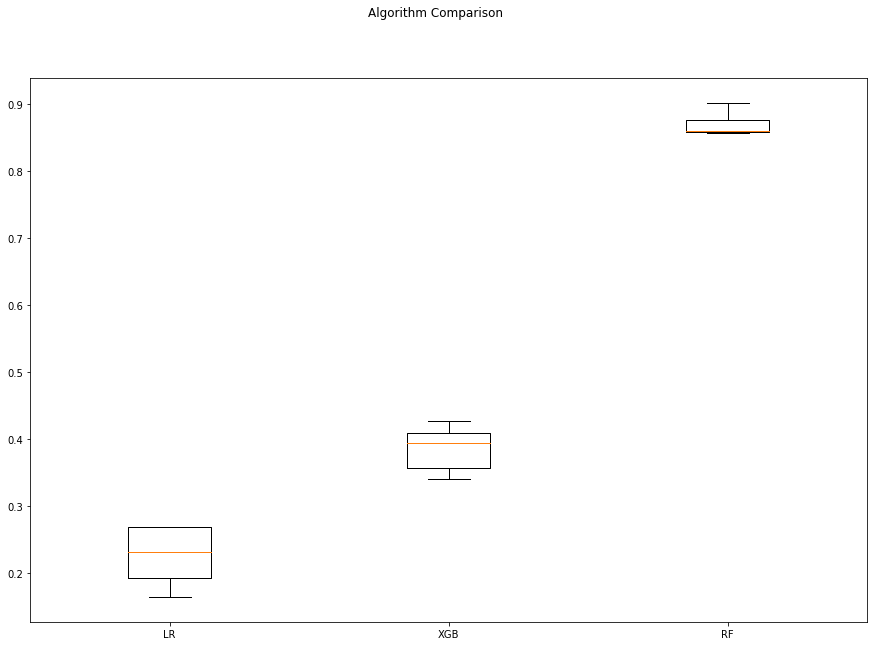

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Preprocessing tests

In [17]:
# Data loading
df_store = pd.read_csv('../data/store.csv')
df_train = pd.read_csv('../data/train.csv', low_memory=False)

In [18]:
# Preprocessing
X, y, X_PCA = pp.Preprocessor().transform(df_store, df_train)
print(X.shape, y.shape, X_PCA.shape)
X.head()

(844392, 22) (844392,) (844392, 13)


,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,cos_DayOfWeek,sin_DayOfWeek,...,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,CompetitionOpenSince,Promo2Since
0,5,2015-07-31,1,1,1,0,0,0,-0.222521,-0.974928,...,0,0,0,0,1,0,0,0,105.0,648.142857
1,4,2015-07-30,1,1,1,0,0,0,-0.900969,-0.433884,...,0,0,0,0,1,0,0,0,105.0,648.142857
2,3,2015-07-29,1,1,1,0,0,0,-0.900969,0.433884,...,0,0,0,0,1,0,0,0,105.0,648.142857
3,2,2015-07-28,1,1,1,0,0,0,-0.222521,0.974928,...,0,0,0,0,1,0,0,0,105.0,648.142857
4,1,2015-07-27,1,1,1,0,0,0,0.623490,0.781831,...,0,0,0,0,1,0,0,0,105.0,648.142857


In [20]:
reg_model = model.Regressor()
train_model(reg_model, X, y)

In [21]:
print(reg_model)

Regressor()
